## Cross-country model for predicting wealth index
In this notebook, we normalized each model feature by country to correct country-specific feature quirks, as well as the wealth index.

This method has been done in a [similar study](https://doi.org/10.1073/pnas.2113658119) using DHS as training data and was also documented [here](https://www.dhsprogram.com/pubs/pdf/MR9/MR9.pdf).

Models recover how relative values of input data (relative to other locations in that country) correlate with relative values of wealth (also relative to other locations in that country).

The current best model setup involves (1) normalizing all features per country using `MinMaxScaler` and (2) scaling the wealth index per country using `StandardScaler`

In [1]:
import sys
sys.path.append("../../")

import os

import uuid
import numpy as np
import geopandas as gpd
import pandas as pd
from shapely import wkt

from geowrangler import dhs
from povertymapping import settings, osm, ookla, nightlights
from povertymapping.dhs import generate_dhs_cluster_level_data
from povertymapping.osm import OsmDataManager
from povertymapping.ookla import OoklaDataManager
import getpass
import pickle

from sklearn.model_selection import train_test_split, KFold, RepeatedKFold
from sklearn.model_selection import GroupKFold, cross_val_predict, cross_val_score, LeaveOneGroupOut
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns

import shap

/home/jace/workspace/unicef-ai4d-relative-wealth/env/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(
/home/jace/workspace/unicef-ai4d-relative-wealth/env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%reload_ext autoreload
%autoreload 2

## Set up Data Access

In [3]:
# # Instantiate data managers for Ookla and OSM
# # This auto-caches requested data in RAM, so next fetches of the data are faster.
osm_data_manager = OsmDataManager(cache_dir=settings.ROOT_DIR/"data/data_cache")
ookla_data_manager = OoklaDataManager(cache_dir=settings.ROOT_DIR/"data/data_cache")

In [4]:
# Log-in using EOG credentials
username = os.environ.get('EOG_USER',None)
username = username if username is not None else input('Username?')
password = os.environ.get('EOG_PASSWORD',None)
password = password if password is not None else getpass.getpass('Password?') 

# set save_token to True so that access token gets stored in ~/.eog_creds/eog_access_token
access_token = nightlights.get_eog_access_token(username,password, save_token=True)

2023-02-13 16:07:15.849 | INFO     | povertymapping.nightlights:get_eog_access_token:48 - Saving access_token to ~/.eog_creds/eog_access_token
2023-02-13 16:07:15.851 | INFO     | povertymapping.nightlights:get_eog_access_token:56 - Adding access token to environmentt var EOG_ACCESS_TOKEN


## Load Countries From DHS data

In [5]:
# Set country-specific variables
country_config = {
    'Philippines': {
        'country_osm':'philippines',
        'ookla_year': 2019,
        'nightlights_year' : 2017,
        'country_code': 'ph',
        'dhs_household_dta_path' : settings.DATA_DIR/"dhs/ph/PHHR71DT/PHHR71FL.DTA",
        'dhs_geographic_shp_path' : settings.DATA_DIR/"dhs/ph/PHGE71FL/PHGE71FL.shp"
    },
    'Timor Leste': {
        'country_osm':'east-timor',
        'ookla_year': 2019,
        'nightlights_year' : 2016,
        'country_code': 'tl',
        'dhs_household_dta_path' : settings.DATA_DIR/"dhs/tl/TLHR71DT/TLHR71FL.DTA",
        'dhs_geographic_shp_path' : settings.DATA_DIR/"dhs/tl/TLGE71FL/TLGE71FL.shp"
    },
    'Cambodia': {
        'country_osm':'cambodia',
        'ookla_year': 2019,
        'nightlights_year' : 2014,
        'country_code': 'kh',
        'dhs_household_dta_path' : settings.DATA_DIR/"dhs/kh/KHHR73DT/KHHR73FL.DTA",
        'dhs_geographic_shp_path' : settings.DATA_DIR/"dhs/kh/KHGE71FL/KHGE71FL.shp"
    },
    'Myanmar': {
        'country_osm':'myanmar',
        'ookla_year': 2019,
        'nightlights_year' : 2015,
        'country_code': 'mm',
        'dhs_household_dta_path' : settings.DATA_DIR/"dhs/mm/MMHR71DT/MMHR71FL.DTA",
        'dhs_geographic_shp_path' : settings.DATA_DIR/"dhs/mm/MMGE71FL/MMGE71FL.shp"
    }
}

### Combine base features for all four countries
This section creates `countries_data (pd.DataFrame)` which combines DHS/Ookla/OSM/VIIRS data for all specified countries.

In [6]:
%%time

# Create list of dataframes per country, and list of all columns appearing in DHS columns
country_data_list = []
dhs_columns = ['DHSCLUST']

for country, config in country_config.items():
    print(f'Loading data for {country}')

    # Load the DHS cluster data
    dhs_household_dta_path = config['dhs_household_dta_path']
    dhs_geographic_shp_path = config['dhs_geographic_shp_path']
    country_code = config['country_code']
    dhs_gdf = generate_dhs_cluster_level_data(
        dhs_household_dta_path, 
        dhs_geographic_shp_path, 
        col_rename_config=country_code,
        convert_geoms_to_bbox=True,
        bbox_size_km = 2.4
    ).reset_index(drop=True)

    dhs_columns = list(set(dhs_columns + list(dhs_gdf.columns)))
    

    # Generate base features for the dhs dataframe
    country_data = dhs_gdf.copy()
    country_osm = config['country_osm']
    ookla_year = config['ookla_year']
    nightlights_year = config['nightlights_year']
    
    # Add in OSM features
    country_data = osm.add_osm_poi_features(country_data, country_osm, osm_data_manager)
    country_data = osm.add_osm_road_features(country_data, country_osm, osm_data_manager)

    # Add in Ookla features
    country_data = ookla.add_ookla_features(country_data, 'fixed', ookla_year, ookla_data_manager)
    country_data = ookla.add_ookla_features(country_data, 'mobile', ookla_year, ookla_data_manager)

    # Add in the nighttime lights features
    country_data = nightlights.generate_nightlights_feature(country_data, nightlights_year) 

    country_data_list.append(country_data)

# Combine all country data into a single dataframe
countries_data = gpd.GeoDataFrame(pd.concat(country_data_list,ignore_index=True), crs=country_data_list[0].crs)


Loading data for Philippines


2023-02-13 16:08:25.879 | INFO     | povertymapping.osm:download_osm_country_data:187 - OSM Data: Cached data available for philippines at /home/jace/workspace/unicef-ai4d-relative-wealth/notebooks/2023-01-24-dhs-cross-country-experiments/../../data/data_cache/osm/philippines? True
2023-02-13 16:08:25.881 | DEBUG    | povertymapping.osm:load_pois:149 - OSM POIs for philippines being loaded from /home/jace/workspace/unicef-ai4d-relative-wealth/notebooks/2023-01-24-dhs-cross-country-experiments/../../data/data_cache/osm/philippines/gis_osm_pois_free_1.shp
2023-02-13 16:08:35.008 | INFO     | povertymapping.osm:download_osm_country_data:187 - OSM Data: Cached data available for philippines at /home/jace/workspace/unicef-ai4d-relative-wealth/notebooks/2023-01-24-dhs-cross-country-experiments/../../data/data_cache/osm/philippines? True
2023-02-13 16:08:35.009 | DEBUG    | povertymapping.osm:load_roads:168 - OSM Roads for philippines being loaded from /home/jace/workspace/unicef-ai4d-relativ

Loading data for Timor Leste


2023-02-13 16:10:10.957 | INFO     | povertymapping.osm:download_osm_country_data:187 - OSM Data: Cached data available for east-timor at /home/jace/workspace/unicef-ai4d-relative-wealth/notebooks/2023-01-24-dhs-cross-country-experiments/../../data/data_cache/osm/east-timor? True
2023-02-13 16:10:10.958 | DEBUG    | povertymapping.osm:load_pois:149 - OSM POIs for east-timor being loaded from /home/jace/workspace/unicef-ai4d-relative-wealth/notebooks/2023-01-24-dhs-cross-country-experiments/../../data/data_cache/osm/east-timor/gis_osm_pois_free_1.shp
2023-02-13 16:10:12.045 | INFO     | povertymapping.osm:download_osm_country_data:187 - OSM Data: Cached data available for east-timor at /home/jace/workspace/unicef-ai4d-relative-wealth/notebooks/2023-01-24-dhs-cross-country-experiments/../../data/data_cache/osm/east-timor? True
2023-02-13 16:10:12.046 | DEBUG    | povertymapping.osm:load_roads:168 - OSM Roads for east-timor being loaded from /home/jace/workspace/unicef-ai4d-relative-wealt

Loading data for Cambodia


2023-02-13 16:10:17.428 | INFO     | povertymapping.osm:download_osm_country_data:187 - OSM Data: Cached data available for cambodia at /home/jace/workspace/unicef-ai4d-relative-wealth/notebooks/2023-01-24-dhs-cross-country-experiments/../../data/data_cache/osm/cambodia? True
2023-02-13 16:10:17.429 | DEBUG    | povertymapping.osm:load_pois:149 - OSM POIs for cambodia being loaded from /home/jace/workspace/unicef-ai4d-relative-wealth/notebooks/2023-01-24-dhs-cross-country-experiments/../../data/data_cache/osm/cambodia/gis_osm_pois_free_1.shp
2023-02-13 16:10:19.195 | INFO     | povertymapping.osm:download_osm_country_data:187 - OSM Data: Cached data available for cambodia at /home/jace/workspace/unicef-ai4d-relative-wealth/notebooks/2023-01-24-dhs-cross-country-experiments/../../data/data_cache/osm/cambodia? True
2023-02-13 16:10:19.195 | DEBUG    | povertymapping.osm:load_roads:168 - OSM Roads for cambodia being loaded from /home/jace/workspace/unicef-ai4d-relative-wealth/notebooks/20

Loading data for Myanmar


2023-02-13 16:10:31.819 | INFO     | povertymapping.osm:download_osm_country_data:187 - OSM Data: Cached data available for myanmar at /home/jace/workspace/unicef-ai4d-relative-wealth/notebooks/2023-01-24-dhs-cross-country-experiments/../../data/data_cache/osm/myanmar? True
2023-02-13 16:10:31.820 | DEBUG    | povertymapping.osm:load_pois:149 - OSM POIs for myanmar being loaded from /home/jace/workspace/unicef-ai4d-relative-wealth/notebooks/2023-01-24-dhs-cross-country-experiments/../../data/data_cache/osm/myanmar/gis_osm_pois_free_1.shp
2023-02-13 16:10:34.204 | INFO     | povertymapping.osm:download_osm_country_data:187 - OSM Data: Cached data available for myanmar at /home/jace/workspace/unicef-ai4d-relative-wealth/notebooks/2023-01-24-dhs-cross-country-experiments/../../data/data_cache/osm/myanmar? True
2023-02-13 16:10:34.205 | DEBUG    | povertymapping.osm:load_roads:168 - OSM Roads for myanmar being loaded from /home/jace/workspace/unicef-ai4d-relative-wealth/notebooks/2023-01-2

CPU times: user 2min 21s, sys: 1min 9s, total: 3min 30s
Wall time: 3min 37s


### Inspect the combined target country data

In [7]:
countries_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2720 entries, 0 to 2719
Data columns (total 86 columns):
 #   Column                             Non-Null Count  Dtype   
---  ------                             --------------  -----   
 0   DHSCLUST                           2720 non-null   int64   
 1   Wealth Index                       2720 non-null   float64 
 2   DHSID                              2720 non-null   object  
 3   DHSCC                              2720 non-null   object  
 4   DHSYEAR                            2720 non-null   float64 
 5   CCFIPS                             2720 non-null   object  
 6   ADM1FIPS                           2720 non-null   object  
 7   ADM1FIPSNA                         2720 non-null   object  
 8   ADM1SALBNA                         2720 non-null   object  
 9   ADM1SALBCO                         2720 non-null   object  
 10  ADM1DHS                            2720 non-null   float64 
 11  ADM1NAME                           

In [8]:
# Check if DHS CC can be used as a country grouping column
countries_data['DHSCC'].value_counts()

PH    1213
KH     611
TL     455
MM     441
Name: DHSCC, dtype: int64

In [9]:
# Explore as a map with first 30 columns in tooltip
#countries_data.iloc[:, :30].explore()

## Data Preparation

### Split into labels and features

In [10]:
# Set parameters
label_col = 'Wealth Index'
group_col = 'DHSCC'
##normalize_labels = 'single-country' # False, 'cross-country' or 'single_country'
normalize_labels = 'cross-country'

In [11]:
drop_cols = ['DHSID', 'DHSYEAR', 'CCFIPS',
       'ADM1FIPS', 'ADM1FIPSNA', 'ADM1SALBNA', 'ADM1SALBCO', 'ADM1DHS',
       'ADM1NAME', 'DHSREGCO', 'DHSREGNA', 'SOURCE', 'LATNUM',
       'LONGNUM', 'ALT_GPS', 'ALT_DEM', 'DATUM','F21','F22','F23','URBAN_RURA']

In [12]:
# Split train/test data into features and labels

# For labels, we just select the target label column
labels = countries_data[[label_col]]

# For features, drop all columns from the input dhs files
# If you need the cluster data, refer to country_data / country_test
features = countries_data.drop(drop_cols, axis=1).copy()

features.shape, labels.shape

((2720, 65), (2720, 1))

### Normalize labels and features

In [13]:
def scale_col(X,scaler):
    X_ = np.atleast_2d(X)
    return pd.DataFrame(scaler.fit_transform(X_), X.index)

In [14]:
feature_cols = features.columns[4:].tolist()
print(feature_cols)

['poi_count', 'atm_count', 'atm_nearest', 'bank_count', 'bank_nearest', 'bus_station_count', 'bus_station_nearest', 'cafe_count', 'cafe_nearest', 'charging_station_count', 'charging_station_nearest', 'courthouse_count', 'courthouse_nearest', 'dentist_count', 'dentist_nearest', 'fast_food_count', 'fast_food_nearest', 'fire_station_count', 'fire_station_nearest', 'food_court_count', 'food_court_nearest', 'fuel_count', 'fuel_nearest', 'hospital_count', 'hospital_nearest', 'library_count', 'library_nearest', 'marketplace_count', 'marketplace_nearest', 'pharmacy_count', 'pharmacy_nearest', 'police_count', 'police_nearest', 'post_box_count', 'post_box_nearest', 'post_office_count', 'post_office_nearest', 'restaurant_count', 'restaurant_nearest', 'social_facility_count', 'social_facility_nearest', 'supermarket_count', 'supermarket_nearest', 'townhall_count', 'townhall_nearest', 'road_count', 'fixed_2019_mean_avg_d_kbps_mean', 'fixed_2019_mean_avg_u_kbps_mean', 'fixed_2019_mean_avg_lat_ms_mean

In [15]:
#scale features
scaler = StandardScaler()
for col in feature_cols:
    print(col)
    features[col+'_scaled'] = features.groupby(group_col, group_keys=False)[[col]].apply(scale_col, scaler=scaler)
print(features.columns)

poi_count
atm_count
atm_nearest
bank_count
bank_nearest
bus_station_count
bus_station_nearest
cafe_count
cafe_nearest
charging_station_count
charging_station_nearest
courthouse_count
courthouse_nearest
dentist_count
dentist_nearest
fast_food_count
fast_food_nearest
fire_station_count
fire_station_nearest
food_court_count
food_court_nearest
fuel_count
fuel_nearest
hospital_count
hospital_nearest
library_count
library_nearest
marketplace_count
marketplace_nearest
pharmacy_count
pharmacy_nearest
police_count
police_nearest
post_box_count
post_box_nearest
post_office_count
post_office_nearest
restaurant_count
restaurant_nearest
social_facility_count
social_facility_nearest
supermarket_count
supermarket_nearest
townhall_count
townhall_nearest
road_count
fixed_2019_mean_avg_d_kbps_mean
fixed_2019_mean_avg_u_kbps_mean
fixed_2019_mean_avg_lat_ms_mean
fixed_2019_mean_num_tests_mean
fixed_2019_mean_num_devices_mean
mobile_2019_mean_avg_d_kbps_mean
mobile_2019_mean_avg_u_kbps_mean
mobile_2019_mea

In [16]:
# fill nas with 0
features = features.fillna(0)

(array([ 16.,  85., 442., 702., 533., 379., 308., 179.,  68.,   8.]),
 array([-2.65317484, -2.0616477 , -1.47012056, -0.87859342, -0.28706627,
         0.30446087,  0.89598801,  1.48751515,  2.0790423 ,  2.67056944,
         3.26209658]),
 <BarContainer object of 10 artists>)

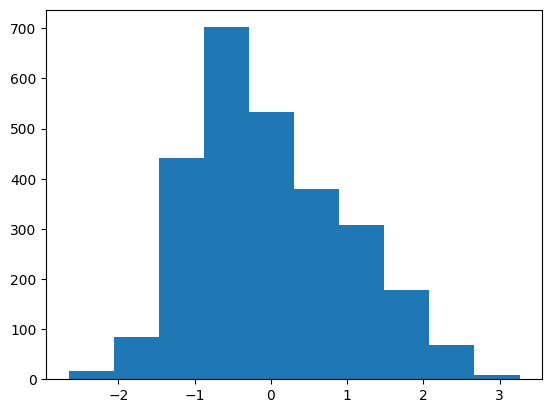

In [17]:
# # scale labels
scaler = StandardScaler()
labels = countries_data[[group_col,label_col]].groupby(group_col, group_keys=False)[[label_col]].apply(scale_col, scaler=scaler)
plt.hist(labels)

In [18]:
# keep only scaled columns
features = features[[col+'_scaled' for col in feature_cols]]

### Base Features List

The features can be subdivided by the source dataset

#### OSM
- `<poi type>_count`: number of points of interest (POI) of a specified type in that area
    - ex. atm_count: number of atms in cluster
    - poi_count: number of all POIs *of all types* in cluster 
- `<poi_type>_nearest`: distance of nearest POI of the specified type
    - ex. atm_nearest: distance of nearest ATM from that cluster
- OSM POI types included: `atm`, `bank`, `bus_stations`, `cafe`, `charging_station`, `courthouse`, `dentist` (clinic), `fast_food`, `fire_station`, `food_court`, `fuel` (gas station), `hospital`, `library`, `marketplace`, `pharmacy`, `police`, `post_box`, `post_office`, `restaurant`, `social_facility`, `supermarket`, `townhall`, `road`

#### Ookla 
The network metrics features follow the following name convention:

> `<type>_<year>_<yearly aggregate>_<network variable>_<cluster aggregate>`

- type: kind of network connection measured
    - fixed: connection from fixed sources (landline, fiber, etc.)
    - mobile: connection from mobile devices
- year: Year of source data
- yearly aggregate: How data was aggregated into yearly data
    - Note: Ookla provides data per quarter, so a yearly mean takes the average across 4 quarters
    - For this model, we only aggregate by yearly mean
- network variable: network characteristic described
    - avg_d_kbps: average download speed in kbps
    - avg_u_kbps: average upload speed in kbps
    - avg_lat_ms: average latency in ms
    - num_devices: number of devices measured
- cluster aggregate: how the data was aggregated per cluster aggregate
    - Types: min, mean, max, median, std.
        - For this model: only mean is used 
    - This is calculated using area zonal stats, which weighs the average by the intersection of the Ookla tile with the cluster geometry.
    
    
Ex. `fixed_2019_mean_avg_d_kbps_median` takes the cluster median of 2019 yearly average download speed.


#### Nightlights (VIIRS)
All nightlights features are taken as the zonal aggregate of the raster data per cluster

- ex. `avg_rad_mean`: cluster mean of the average radiance 
- aggregations used: min, mean, max, median


In [19]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2720 entries, 0 to 2719
Data columns (total 61 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   poi_count_scaled                          2720 non-null   float64
 1   atm_count_scaled                          2720 non-null   float64
 2   atm_nearest_scaled                        2720 non-null   float64
 3   bank_count_scaled                         2720 non-null   float64
 4   bank_nearest_scaled                       2720 non-null   float64
 5   bus_station_count_scaled                  2720 non-null   float64
 6   bus_station_nearest_scaled                2720 non-null   float64
 7   cafe_count_scaled                         2720 non-null   float64
 8   cafe_nearest_scaled                       2720 non-null   float64
 9   charging_station_count_scaled             2720 non-null   float64
 10  charging_station_nearest_scaled     

## Model Training

In [20]:
# Set parameters
groupkfold_col = 'DHSCC'
# cv_num_splits = 5
# cv_num_repeats = 5
train_test_seed = 42
test_size = 0.2

### Create train/test cross-validation indices

In [21]:
# train_features, test_features, train_labels, test_labels = train_test_split(
#     features, labels, test_size=test_size, random_state=train_test_seed
# )

# Cross validation
print(f"Performing GroupKFold CV with groups based on DHSCC...")
groups = countries_data[groupkfold_col].values
cv = GroupKFold(n_splits = len(set(groups)))

print(cv.split(features, groups=groups))
print(f'Number of splits based on DHSCC unique values: {cv.get_n_splits()}')


Performing GroupKFold CV with groups based on DHSCC...
<generator object _BaseKFold.split at 0x7f6d50d022e0>
Number of splits based on DHSCC unique values: 4


### Instantiate model
For now, we will train a simple random forest model

In [22]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, random_state=train_test_seed, verbose=0)
model

RandomForestRegressor(random_state=42)

### Evaluate model training using cross-validation
We evalute the model's generalizability when training over different train/test splits

Ideally for R^2

- We want a high mean: This means that we achieve a high model performance over the different train/test splits
- We want a low standard deviation (std): This means that the model performance is stable over multiple training repetitions

Split# 1
Train countries (num samples): {'KH', 'MM', 'TL'} (1507)
Test countries (num samples): {'PH'} (1213)
Split r^2: 0.48054801637734346 



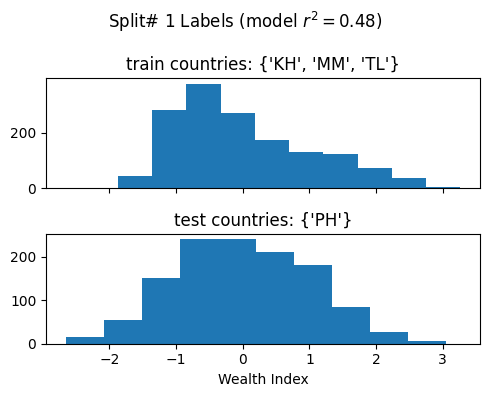

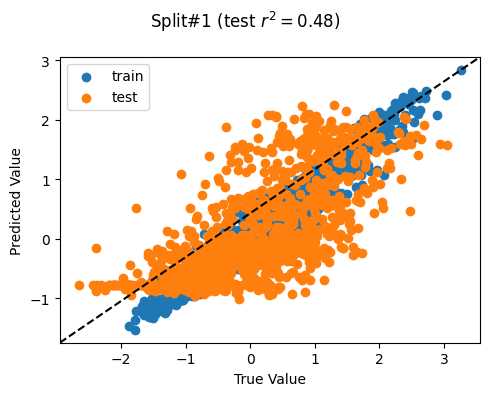

Split# 2
Train countries (num samples): {'MM', 'TL', 'PH'} (2109)
Test countries (num samples): {'KH'} (611)
Split r^2: 0.5834437437650173 



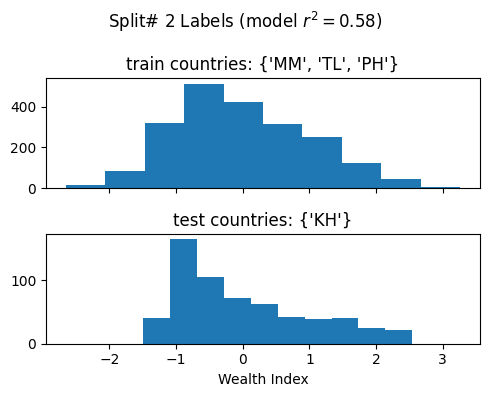

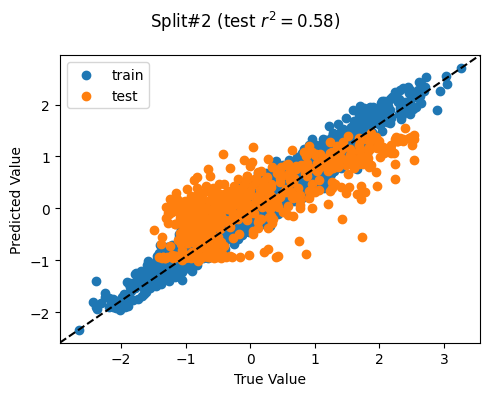

Split# 3
Train countries (num samples): {'KH', 'MM', 'PH'} (2265)
Test countries (num samples): {'TL'} (455)
Split r^2: 0.5350537480791098 



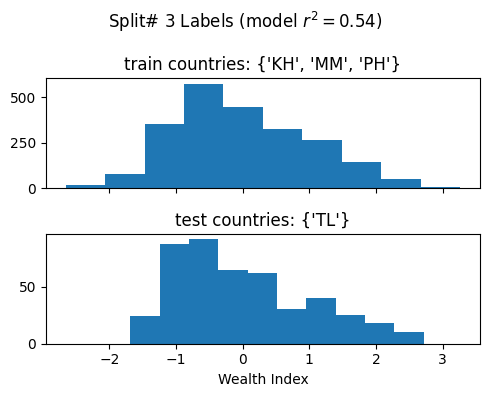

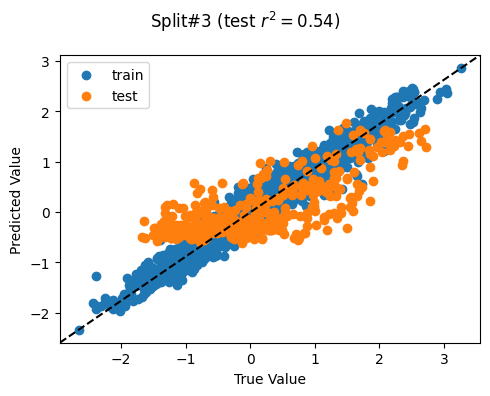

Split# 4
Train countries (num samples): {'KH', 'TL', 'PH'} (2279)
Test countries (num samples): {'MM'} (441)
Split r^2: 0.5055486937348812 



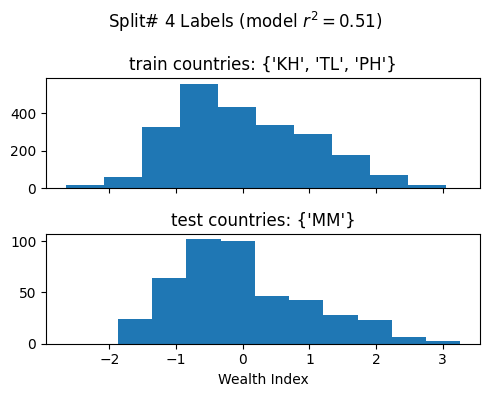

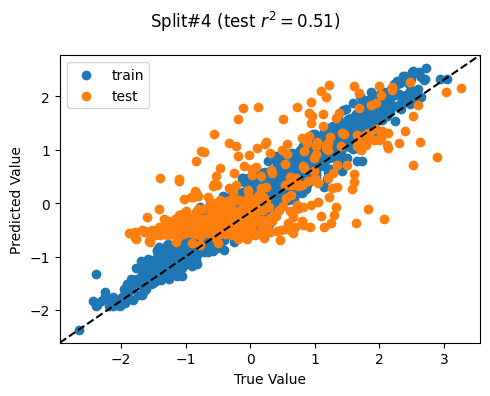

Mean split r^2  (std): 0.5261 (0.0383)


In [23]:
split_r2_list = []

for i, (train, test) in enumerate(cv.split(features, labels,groups=groups)):
    print(f'Split# {i+1}')

    # Print info about current split
    train_labels = set(groups[train])
    test_labels = set(groups[test])
    print(f'Train countries (num samples): {train_labels} ({len(train)})')
    print(f'Test countries (num samples): {test_labels} ({len(test)})')

    # Split data into train/test
    X_train = features.values[train]
    X_test = features.values[test]
    y_train = labels.values.ravel()[train]
    y_test = labels.values.ravel()[test]

    # print('Input shapes (X_train, X_test, y_train, y_test): ',np.shape(X_train), np.shape(X_test), np.shape(y_train), np.shape(y_test))

    # Train model and get r2
    model.fit(X_train, y_train)
    split_r2 = r2_score(y_test, model.predict(X_test))
    split_r2_list.append(split_r2)
    print(f'Split r^2: {split_r2} \n')

    # Plot histogram of labels
    fig, ax = plt.subplots(2,1, sharex=True, figsize=(5,4))
    ax[0].hist(y_train)
    ax[0].set_title(f'train countries: {train_labels}')
    ax[1].hist(y_test)
    ax[1].set_title(f'test countries: {test_labels}')
    ax[1].set_xlabel('Wealth Index')
    fig.suptitle(f'Split# {i+1} Labels (model $r^2 = {round(split_r2,2)}$)')
    plt.tight_layout()
    plt.show()

    # Plot scatter plot
    fig, ax = plt.subplots(1,1, figsize=(5,4))
    ax.scatter(y_train, model.predict(X_train), label="train")
    ax.scatter(y_test, model.predict(X_test), label="test")
    ax.plot([0,1],[0,1], transform=ax.transAxes, linestyle='dashed', color='k')
    ax.set_xlabel("True Value")
    ax.set_ylabel("Predicted Value")
    ax.legend()    
    fig.suptitle(f'Split#{i+1} (test $r^2 = {round(split_r2,2)}$)')
    plt.tight_layout()
    plt.show()

split_r2_mean = round(np.array(split_r2_list).mean(), 4)
split_r2_std = round(np.array(split_r2_list).std(), 4)
print(f'Mean split r^2  (std): {split_r2_mean} ({split_r2_std})')



In [24]:
# explainer = shap.TreeExplainer(model)
# shap_values = explainer.shap_values(features)

In [25]:
# shap.summary_plot(shap_values, features, feature_names=features.columns, plot_type="bar")